In [20]:
import polars as pl

df = pl.read_csv("../data/score_v2.csv")
df = (
    df.with_columns(
        method=pl.col("method").replace(
            {
                "das_ag": "DAS-AG",
                "das": "DAS",
                "das_rag": "DAS-rAG",
                "das_ag_plus": "DAS-AG+",
                "das_rag_plus": "DAS-rAG+",
            }
        ),
    )
    .sort("aesthetic_score", descending=True)
    .with_columns(
        rank_per_method=pl.col("aesthetic_score").cum_count().over("method"),
    )
)

stat_df = df.group_by("method", maintain_order=True).agg(
    aesthetic_score_mean=pl.col("aesthetic_score").mean(),
    aesthetic_score_std=pl.col("aesthetic_score").std(),
    clip_score_mean=pl.col("pos_clip_score").mean(),
    clip_score_std=pl.col("pos_clip_score").std(),
)
stat_df.write_csv("../data/stat_v2.csv")
stat_df

method,aesthetic_score_mean,aesthetic_score_std,clip_score_mean,clip_score_std
str,f64,f64,f64,f64
"""DAS-AG+""",6.155469,0.311502,0.174451,0.036928
"""DAS-AG""",5.258594,0.472627,0.249927,0.027372
"""DAS""",3.5140625,0.171561,0.343896,0.012636
"""DAS-rAG""",0.412134,0.1251,0.268848,0.026533
"""DAS-rAG+""",-0.554492,0.524077,0.237061,0.034473


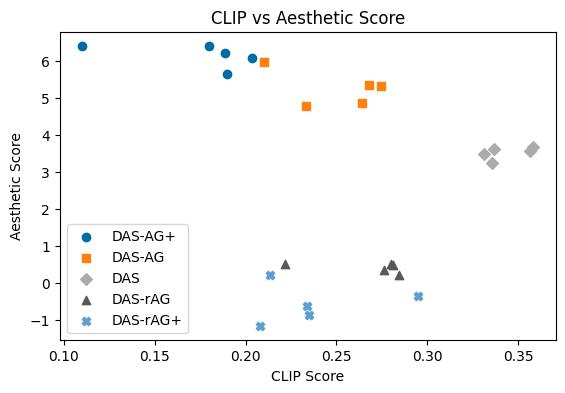

In [104]:
import matplotlib.pyplot as plt

plt.style.use("tableau-colorblind10")

fig, ax = plt.subplots(figsize=(8 * 0.8, 5 * 0.8))
markers = ["o", "s", "D", "^", "X"]
for ((method,), df_), marker in zip(
    df.group_by("method", maintain_order=True), markers
):
    ax.scatter(df_["pos_clip_score"], df_["aesthetic_score"], marker=marker, label=method)

ax.set(ylabel="Aesthetic Score", xlabel="CLIP Score", title="CLIP vs Aesthetic Score")
ax.legend()
fig.savefig("../data/score_scatter_v2.png", dpi=300, bbox_inches="tight")

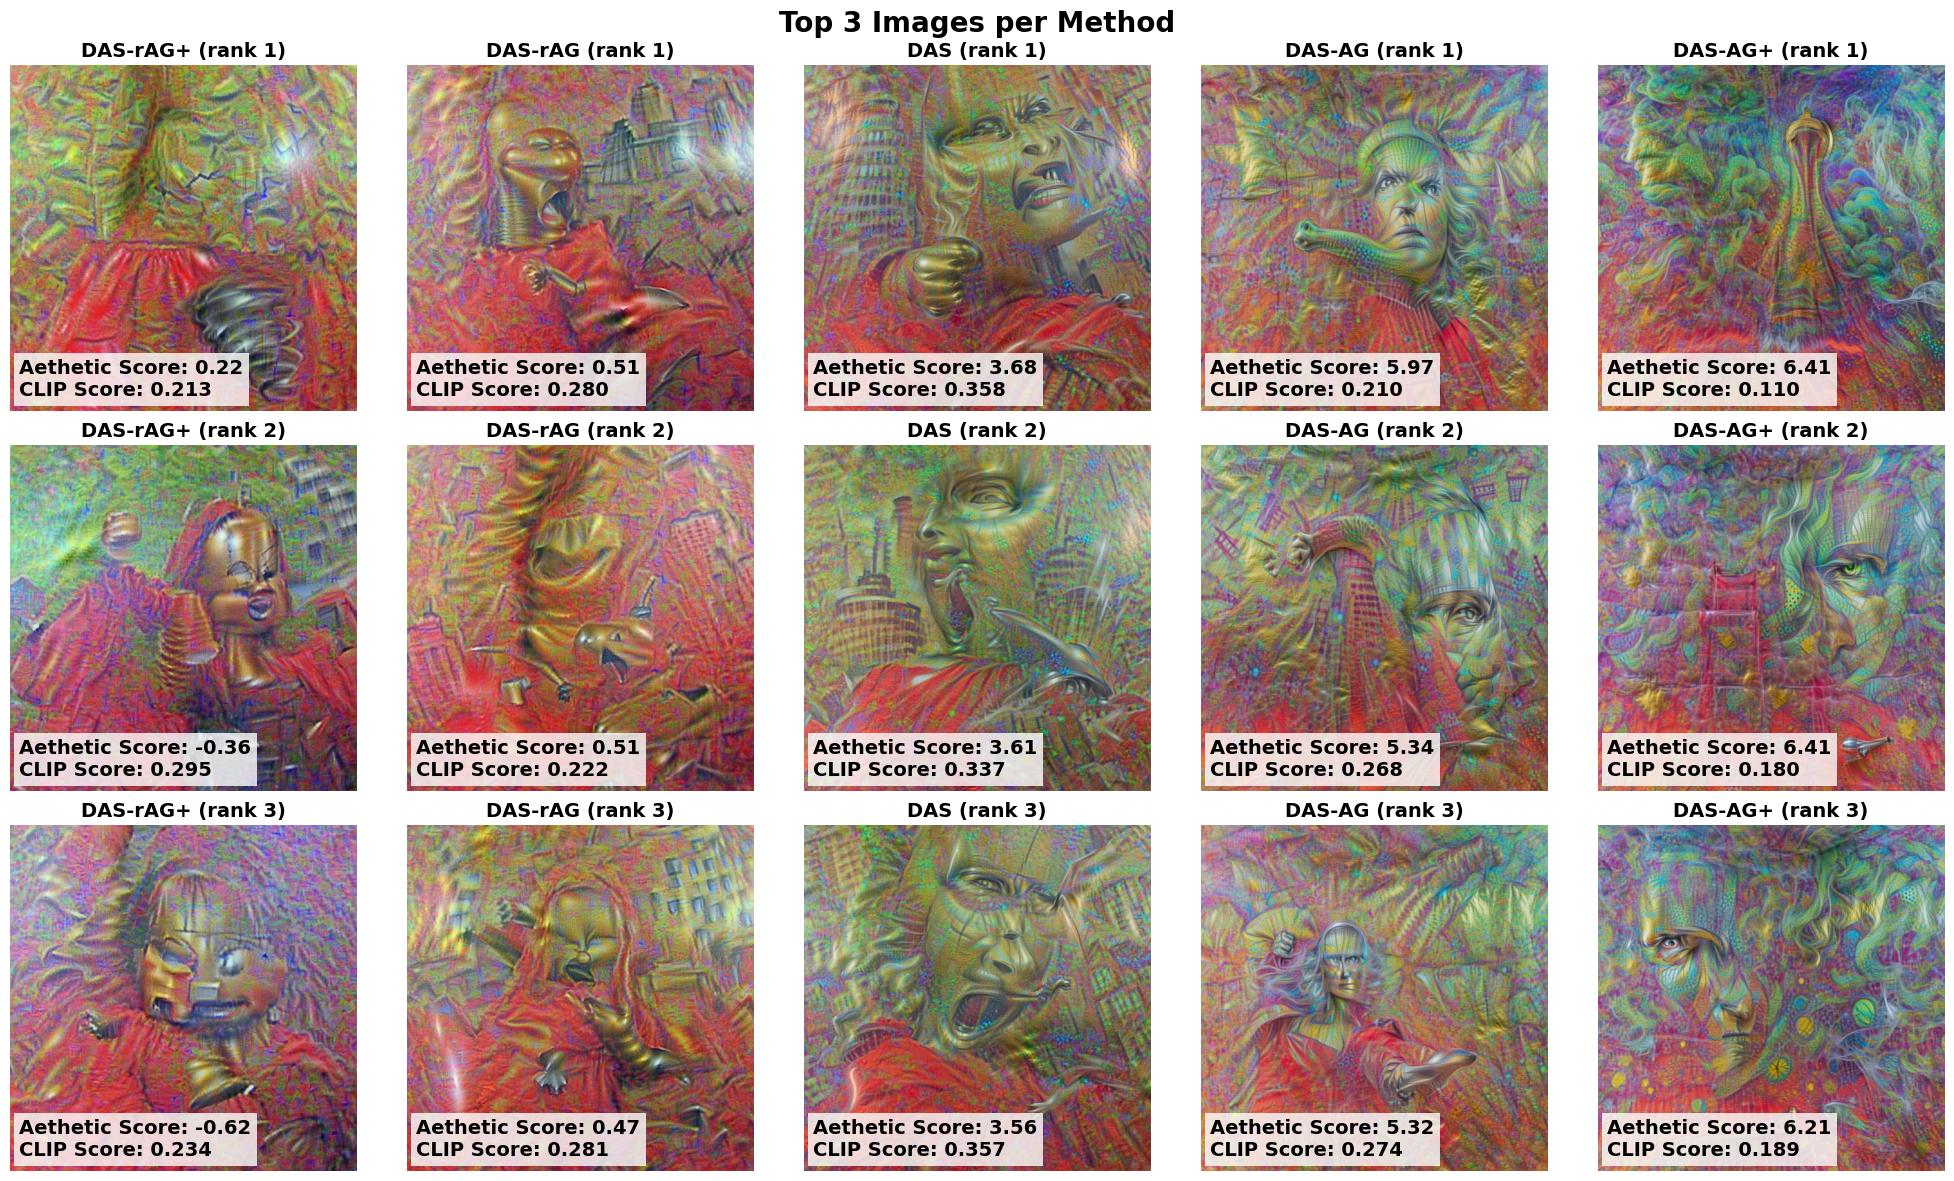

In [102]:
from PIL import Image
from IPython.display import display

fig, axes = plt.subplots(3, 5, figsize=(20, 12), sharex=True, sharey=True)
for i, (method, df_) in enumerate(
    df.sort("aesthetic_score")
    .filter(pl.col("rank_per_method") < 4)
    .group_by("method", maintain_order=True)
):
    for j, row in enumerate(df_.iter_rows()):
        data = dict(zip(df_.columns, row))
        ax = axes[2 - j][i]
        rank = data["rank_per_method"]
        image = Image.open(f"../data/generated_images_v2/{data['file_hash']}.png")
        ax.imshow(image)
        ax.text(
            20,
            784-50,
            f"Aethetic Score: {data['aesthetic_score']:.2f}\nCLIP Score: {data['pos_clip_score']:.3f}",
            fontsize=14,
            color="black",
            fontweight="bold",
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.8),
        )
        ax.set_title(f"{data['method']} (rank {rank})", fontsize=14, weight="bold")
        ax.set_axis_off()

plt.suptitle("Top 3 Images per Method", fontsize=20, weight="bold")
plt.tight_layout()
fig.savefig("../data/top_images_v2.jpg", dpi=96, bbox_inches="tight")
plt.show()